# Engineering Predictive Alpha Factors

This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices as well as the volume for all tickers from the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2007-2016 time period. Looking ahead, we will use 2014-2016 as our 'out-of-sample' period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.
2. Compute the dollar volume as the product of closing price and trading volume; then select the stocks with at least eight years of data and the lowest average daily rank for this metric. 
3. Compute daily returns and keep only 'inliers' with values between -100% and + 100% as a basic check against data error.
4. Now we're ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of those using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
    - Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib's **momentum** indicators family such as
        - the Average Directional Movement Index (ADX), 
        - the Moving Average Convergence Divergence (MACD), 
        - the Relative Strength Index (RSI), 
        - the Balance of Power (BOP) indictor, or 
        - the Money Flow Index (MFI).
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
    - Create volatility metrics such as the Normalized Average True Range (NATR).
    - Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
    - Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

## Usage tips

- If you experience resource constraints (suddenly restarting Kernel), increase the memory available for Docker Desktop (> Settings > Advanced). If this not possible or you experienced prolonged execution times, reduce the scope of the exercise. The easiest way to do so is to select fewer stocks or a shorter time period, or both.
- You may want to persist intermediate results so you can recover quickly in case something goes wrong. There's an example under the first 'Persist Results' subsection.

## Imports & Settings

In [133]:
import warnings
warnings.filterwarnings('ignore')

In [134]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [136]:
DATA_STORE = Path('..', 'data', 'stock_prices.h5')

In [137]:
START = 2006
END = 2016

In [138]:
with pd.HDFStore(DATA_STORE) as store:
    history = (store['us_stocks']
               .loc[idx[:, str(START):str(END)], ['open', 'high', 'low', 'close', 'volume']]
               .fillna(method='ffill', limit=5) # fill up to five days of missing data with latest
              )
#              .unstack('ticker'))

In [139]:
history.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7531907 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 316.8+ MB


In [140]:
#history.dtypes[history.dtypes == 'object'].index
history.describe()

,open,high,low,close,volume
count,7.531907e+06,7.531907e+06,7.531907e+06,7.531907e+06,7.531907e+06
mean,1.147229e+02,1.161035e+02,1.132083e+02,1.146592e+02,1.664527e+06
std,3.739268e+03,3.774868e+03,3.699035e+03,3.737069e+03,7.151191e+06
min,1.000000e-02,1.000000e-02,8.135525e-03,1.000000e-02,0.000000e+00
25%,1.048154e+01,1.069000e+01,1.026399e+01,1.048000e+01,9.180000e+04
50%,1.983159e+01,2.015068e+01,1.949699e+01,1.983684e+01,3.378600e+05
75%,3.595546e+01,3.645471e+01,3.542811e+01,3.595637e+01,1.174300e+06
max,3.670500e+05,3.768750e+05,3.619500e+05,3.657000e+05,2.304019e+09


In [141]:
history.index = history.index.remove_unused_levels()
history.index.levels

FrozenList([['A', 'AA', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABAX', 'ABBV', 'ABC', 'ABCB', 'ABCO', 'ABFS', 'ABG', 'ABM', 'ABMD', 'ABT', 'ACAD', 'ACAS', 'ACAT', 'ACC', 'ACCL', 'ACCO', 'ACE', 'ACET', 'ACFN', 'ACGL', 'ACHC', 'ACHN', 'ACI', 'ACIW', 'ACLS', 'ACM', 'ACN', 'ACO', 'ACOR', 'ACRE', 'ACRX', 'ACTG', 'ACW', 'ACXM', 'ADBE', 'ADC', 'ADES', 'ADI', 'ADM', 'ADMS', 'ADNC', 'ADP', 'ADS', 'ADSK', 'ADT', 'ADTN', 'ADUS', 'ADVS', 'AE', 'AEC', 'AEE', 'AEGN', 'AEGR', 'AEIS', 'AEL', 'AEO', 'AEP', 'AEPI', 'AERI', 'AES', 'AET', 'AF', 'AFAM', 'AFFX', 'AFG', 'AFH', 'AFL', 'AFOP', 'AFSI', 'AGCO', 'AGEN', 'AGII', 'AGIO', 'AGM', 'AGN', 'AGNC', 'AGO', 'AGTC', 'AGX', 'AGYS', 'AHC', 'AHH', 'AHL', 'AHP', 'AHS', 'AHT', 'AI', 'AIG', 'AIMC', ...], [2006-01-03 00:00:00, 2006-01-04 00:00:00, 2006-01-05 00:00:00, 2006-01-06 00:00:00, 2006-01-09 00:00:00, 2006-01-10 00:00:00, 2006-01-11 00:00:00, 2006-01-12 00:00:00, 2006-01-13 00:00:00, 2006-01-17 00:00:00, 2006-01-18 00:00:00, 20

In [142]:
min_obs = 8 * 252
nobs = history.groupby(level='ticker').size()
keep = nobs[nobs > min_obs].index
history = history.loc[idx[keep, :], :]
history.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6785431 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 284.9+ MB


## Select 500 most-traded stocks prior to 2017

Compute the dollar volume as the product of the adjusted close price and the adjusted volume:

In [143]:
history['dollar_volume'] = history['close'] * history['volume']

In [144]:
ticker_group = history.groupby(level='ticker')
dollar_volumes_top500 = ticker_group['dollar_volume'].sum().sort_values(ascending=False).iloc[:500]
dollar_volumes_top500

ticker
BRK_A    1.634041e+13
AAPL     1.397141e+13
GOOGL    5.559056e+12
BAC      4.711297e+12
C        3.960572e+12
             ...     
UNM      1.472794e+11
SM       1.471763e+11
CROX     1.458707e+11
RAX      1.454223e+11
TPX      1.453325e+11
Name: dollar_volume, Length: 500, dtype: float64

In [145]:
top500 = history.loc[dollar_volumes_top500.index]
top500

open      high        low     close    volume  \
ticker date                                                            
BRK_A  2006-01-03  88250.00  89300.00  88250.000  89300.00   45000.0   
       2006-01-04  89200.00  90300.00  89200.000  89690.00   41000.0   
       2006-01-05  89690.00  89800.00  89500.000  89800.00   45000.0   
       2006-01-06  89800.00  90300.00  89500.000  89500.00   45000.0   
       2006-01-09  89300.00  89900.00  89200.000  89900.00   54000.0   
...                     ...       ...        ...       ...       ...   
TPX    2016-12-23     67.15     67.66     66.600     67.46  362275.0   
       2016-12-27     67.54     69.09     67.470     68.74  420644.0   
       2016-12-28     68.88     69.45     67.805     68.54  422140.0   
       2016-12-29     68.41     69.56     67.790     68.18  456959.0   
       2016-12-30     68.29     69.28     67.690     68.28  592307.0   

                   dollar_volume  
ticker date                       
BRK_A  2006-01-03   4.018500e+09  
       2006-01-04   3.677290e+09  
       2006-01-05   4.041000e+09  
       2006-01-06   4.027500e+09  
       2006-01-09   4.854600e+09  
...                          ...  
TPX    2016-12-23   2.443907e+07  
       2016-12-27   2.891507e+07  
       2016-12-28   2.893348e+07  
       2016-12-29   3.115546e+07  
       2016-12-30   4.044272e+07  

[1369673 rows x 6 columns]

## Remove outliers based on daily returns

In [146]:
daily_returns = top500.groupby('ticker').close.pct_change()
outliers = daily_returns[(daily_returns < daily_returns.quantile(.00001)) |
                         (daily_returns > daily_returns.quantile(.99999))]
print(f'# Observations: {len(outliers):,.0f} | # Tickers: {len(outliers.index.unique("ticker")):,.0f}')

# Observations: 28 | # Tickers: 19


In [147]:
inliers = top500.drop(outliers.index.unique('ticker'), level='ticker')

In [148]:
top200 = (inliers.dollar_volume
          .unstack('ticker')
          .dropna(thresh=min_obs, axis=1)
          .mean()
          .div(1e6)
          .nlargest(200))
top200

ticker
BRK_A    5901.194914
AAPL     5045.651515
GOOGL    2007.604330
BAC      1701.443548
C        1430.325581
            ...     
FITB      136.607119
HOT       136.427205
AZO       136.305807
ITW       135.925033
NEE       135.071820
Length: 200, dtype: float64

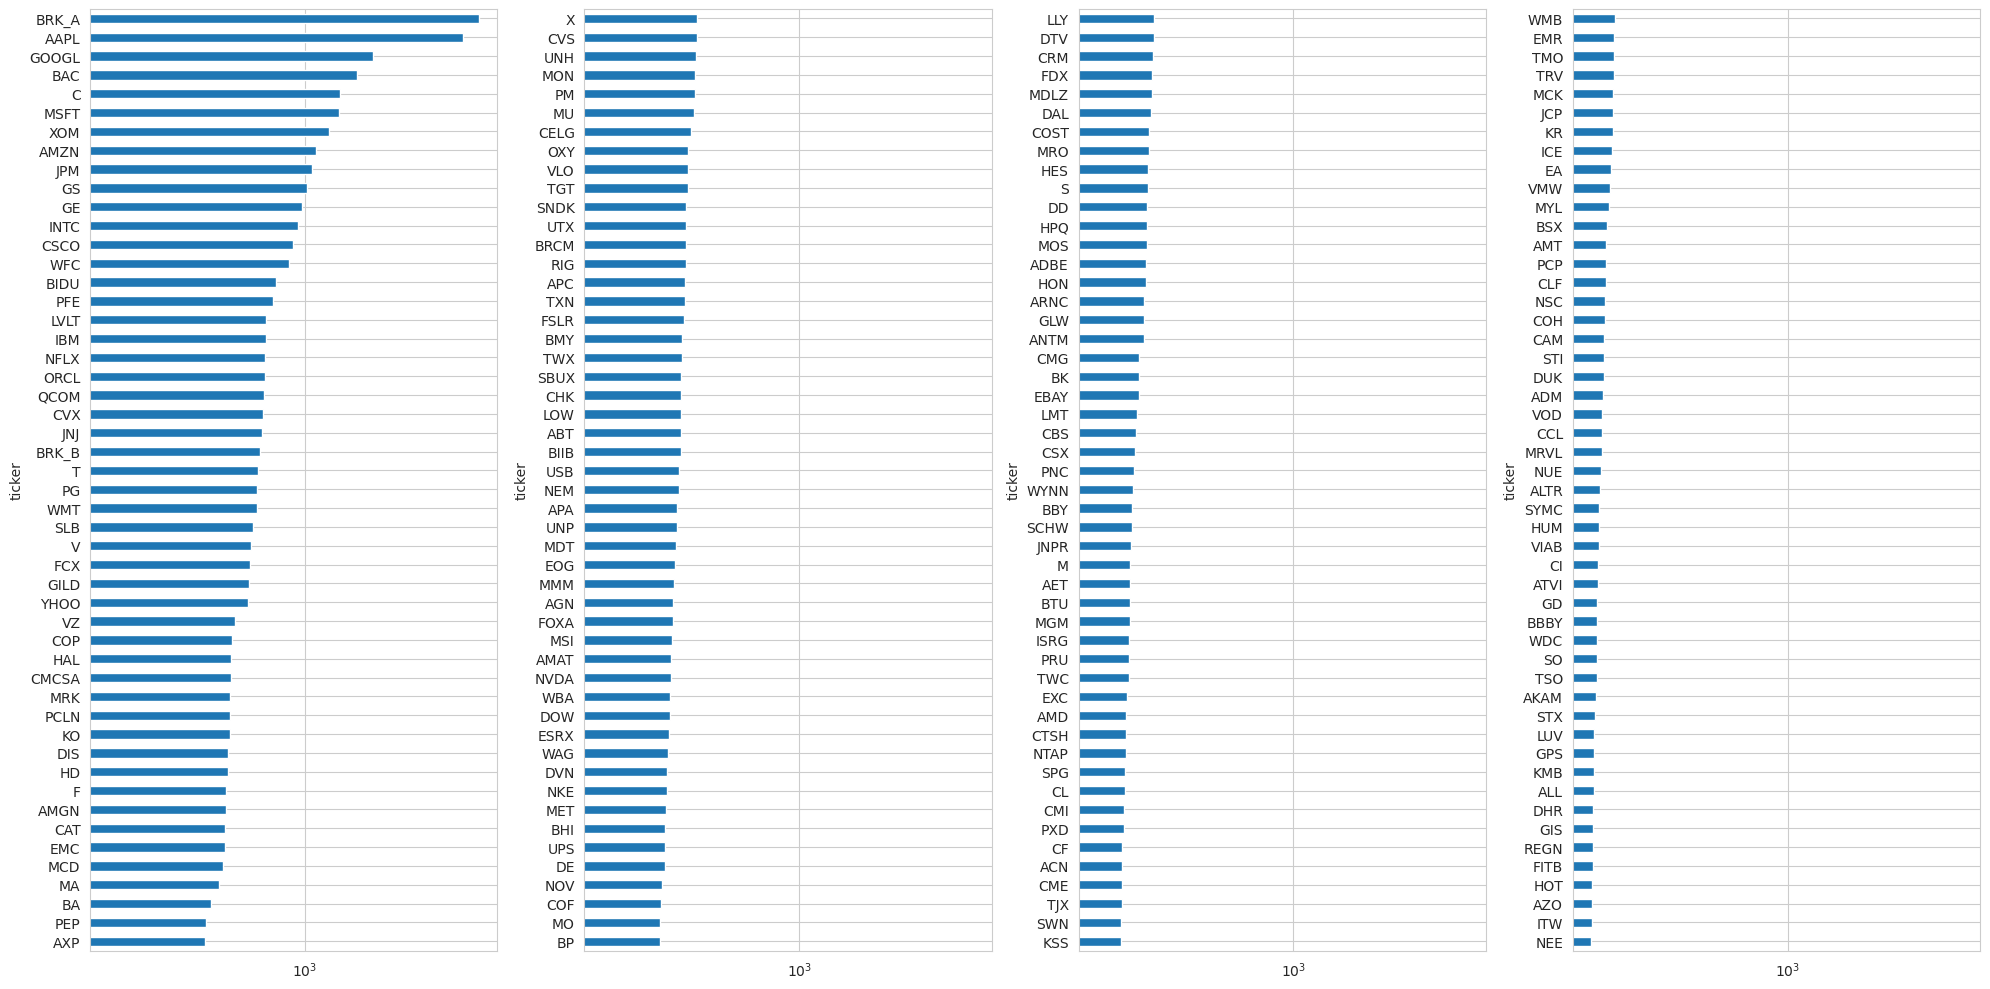

In [149]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()
cutoffs = [0, 50, 100, 150, 200]

for i, cutoff in enumerate(cutoffs[1:], 1):
    top200.iloc[cutoffs[i-1]:cutoffs[i]].sort_values().plot.barh(logx=True, ax=axes[i-1])
fig.tight_layout()

## Compute returns

In [150]:
period = [1, 3, 5, 10, 21, 42, 63, 126, 252]
for p in period:
    inliers[f'ret_{p:02}'] = inliers.groupby('ticker').close.pct_change(p)
inliers

open      high        low     close    volume  \
ticker date                                                            
BRK_A  2006-01-03  88250.00  89300.00  88250.000  89300.00   45000.0   
       2006-01-04  89200.00  90300.00  89200.000  89690.00   41000.0   
       2006-01-05  89690.00  89800.00  89500.000  89800.00   45000.0   
       2006-01-06  89800.00  90300.00  89500.000  89500.00   45000.0   
       2006-01-09  89300.00  89900.00  89200.000  89900.00   54000.0   
...                     ...       ...        ...       ...       ...   
TPX    2016-12-23     67.15     67.66     66.600     67.46  362275.0   
       2016-12-27     67.54     69.09     67.470     68.74  420644.0   
       2016-12-28     68.88     69.45     67.805     68.54  422140.0   
       2016-12-29     68.41     69.56     67.790     68.18  456959.0   
       2016-12-30     68.29     69.28     67.690     68.28  592307.0   

                   dollar_volume    ret_01    ret_03    ret_05    ret_10  \
ticker date                                                                
BRK_A  2006-01-03   4.018500e+09       NaN       NaN       NaN       NaN   
       2006-01-04   3.677290e+09  0.004367       NaN       NaN       NaN   
       2006-01-05   4.041000e+09  0.001226       NaN       NaN       NaN   
       2006-01-06   4.027500e+09 -0.003341  0.002240       NaN       NaN   
       2006-01-09   4.854600e+09  0.004469  0.002341       NaN       NaN   
...                          ...       ...       ...       ...       ...   
TPX    2016-12-23   2.443907e+07  0.006715 -0.018621 -0.001480  0.037048   
       2016-12-27   2.891507e+07  0.018974 -0.003624  0.012371  0.064581   
       2016-12-28   2.893348e+07 -0.002910  0.022832 -0.002910  0.055598   
       2016-12-29   3.115546e+07 -0.005252  0.010673 -0.011741  0.031624   
       2016-12-30   4.044272e+07  0.001467 -0.006692  0.018952  0.030330   

                     ret_21    ret_42    ret_63   ret_126   ret_252  
ticker date                                                          
BRK_A  2006-01-03       NaN       NaN       NaN       NaN       NaN  
       2006-01-04       NaN       NaN       NaN       NaN       NaN  
       2006-01-05       NaN       NaN       NaN       NaN       NaN  
       2006-01-06       NaN       NaN       NaN       NaN       NaN  
       2006-01-09       NaN       NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...       ...  
TPX    2016-12-23  0.061861  0.311176 -0.094497  0.250417 -0.058347  
       2016-12-27  0.060475  0.347843 -0.076696  0.227281 -0.031695  
       2016-12-28  0.091923  0.252101  0.186429  0.201192 -0.040996  
       2016-12-29  0.075394  0.249404  0.234251  0.232466 -0.034961  
       2016-12-30  0.078673  0.262807  0.203384  0.241906 -0.030940  

[1318234 rows x 15 columns]

## Bollinger Bands

In [151]:
SAMPLE_TICKER = 'BRK_A'    # Berkshire Hathaway class A stock
price_sample = inliers.loc[idx[SAMPLE_TICKER, :], :].reset_index('ticker', drop=True)

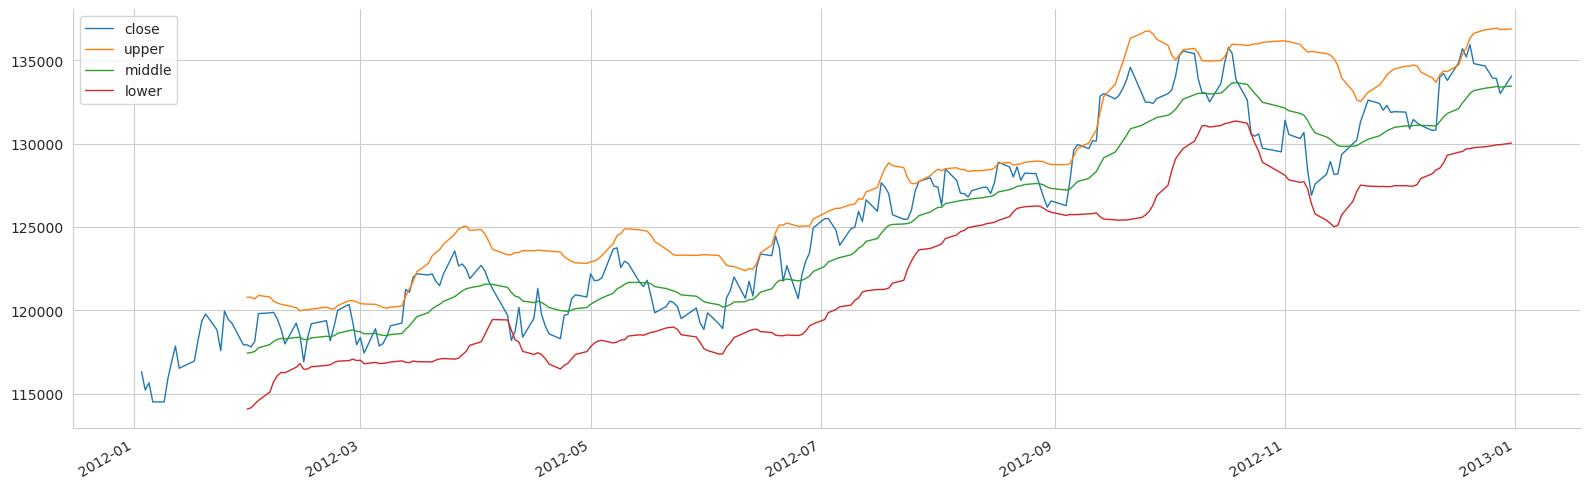

In [152]:
df = price_sample.loc['2012', ['close']]
s = talib.BBANDS(df.close,   # Number of periods (2 to 100000)
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=1      # default: SMA
                 )
bb_bands = ['upper', 'middle', 'lower']

df = price_sample.loc['2012', ['close']]
df = df.assign(**dict(zip(bb_bands, s)))
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 5), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

## Momentum Indicators

TA-Lib offers the following choices - feel free to experiment with as many as you like (but you don't have to..):

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

### Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

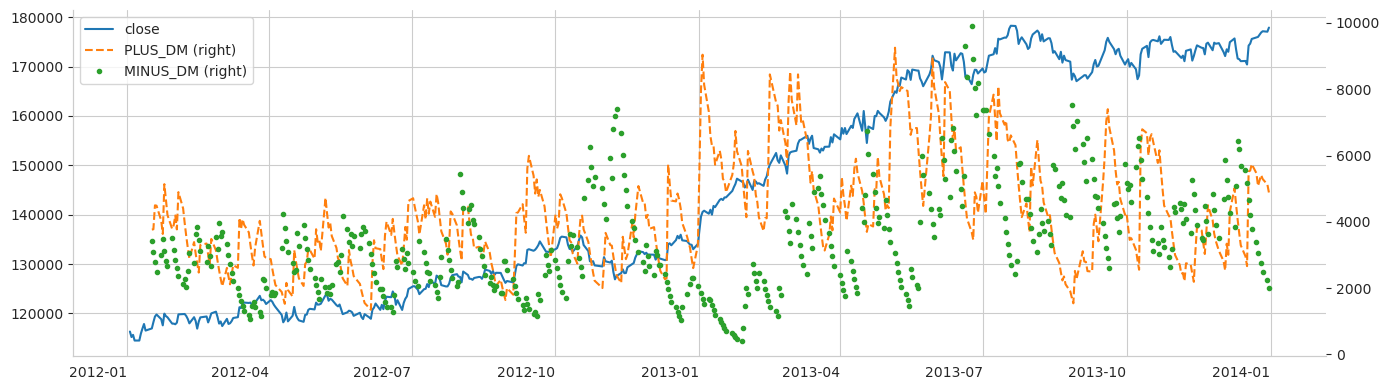

In [153]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]
df['PLUS_DM'] = talib.PLUS_DM(df.high, df.low, timeperiod=10)
df['MINUS_DM'] = talib.MINUS_DM(df.high, df.low, timeperiod=10)

ax = df[['close', 'PLUS_DM', 'MINUS_DM']].plot(figsize=(14, 4),
                                               secondary_y=['PLUS_DM', 'MINUS_DM'],
                                               style=['-', '--', '.'],
                                               rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### Absolute Price Oscillator (APO)

The absolute Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as an absolute value. The EMA windows usually contain 26 and 12 data points, respectively.

### Percentage Price Oscillator (PPO)

The Percentage Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as a percentage value and thus comparable across assets. The EMA windows usually contain 26 and 12 data points, respectively. 

### Aroon Oscillator

#### Aroon Up/Down Indicator

The indicator measures the time between highs and the time between lows over a time period. It computes an AROONUP and an AROONDWN indicator as follows:

$$
\begin{align*}
\text{AROONUP}&=\frac{T-\text{Periods since T period High}}{T}\times 100 \\
\text{AROONDWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

#### Aroon Oscillator

The Aroon Oscillator is simply the difference between the Aroon Up and Aroon Down indicators.

### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

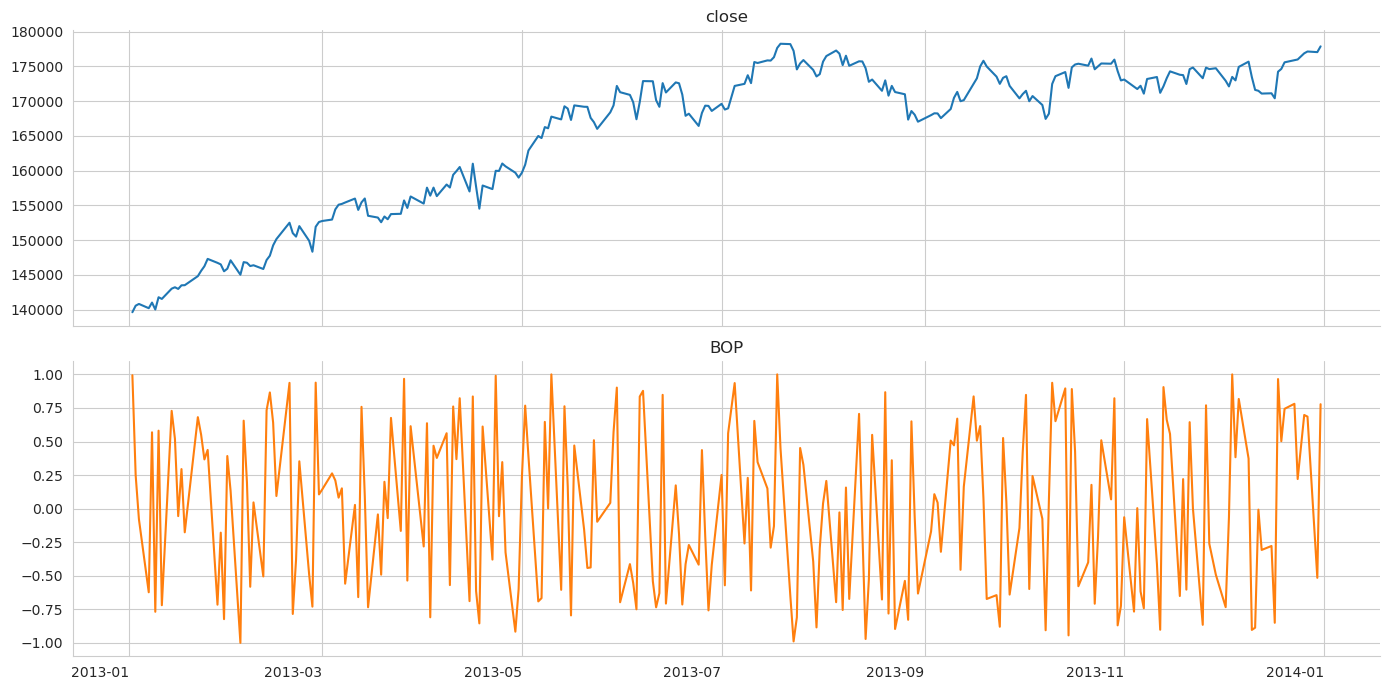

In [154]:
df = price_sample.loc['2013', ['open', 'high', 'low', 'close']]
df['BOP'] = talib.BOP(open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close)
axes = df[['close', 'BOP']].plot(figsize=(14, 7), rot=0, subplots=True, title=['close', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) measures the difference between the current *typical* price, computed as the average of current low, high and close price and the historical average price. A positive (negative) CCI indicates that price is above (below) the historic average. When CCI is below zero, the price is below the hsitoric average. It is computed as:

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

### Chande Momentum Oscillator (CMO)

The Chande Momentum Oscillator (CMO) intends to measure momentum on both up and down days. It is calculated as the difference between the sum of gains and losses over at time period T, divided by the sum of all price movement over the same period. It oscillates between +100 and -100.

### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

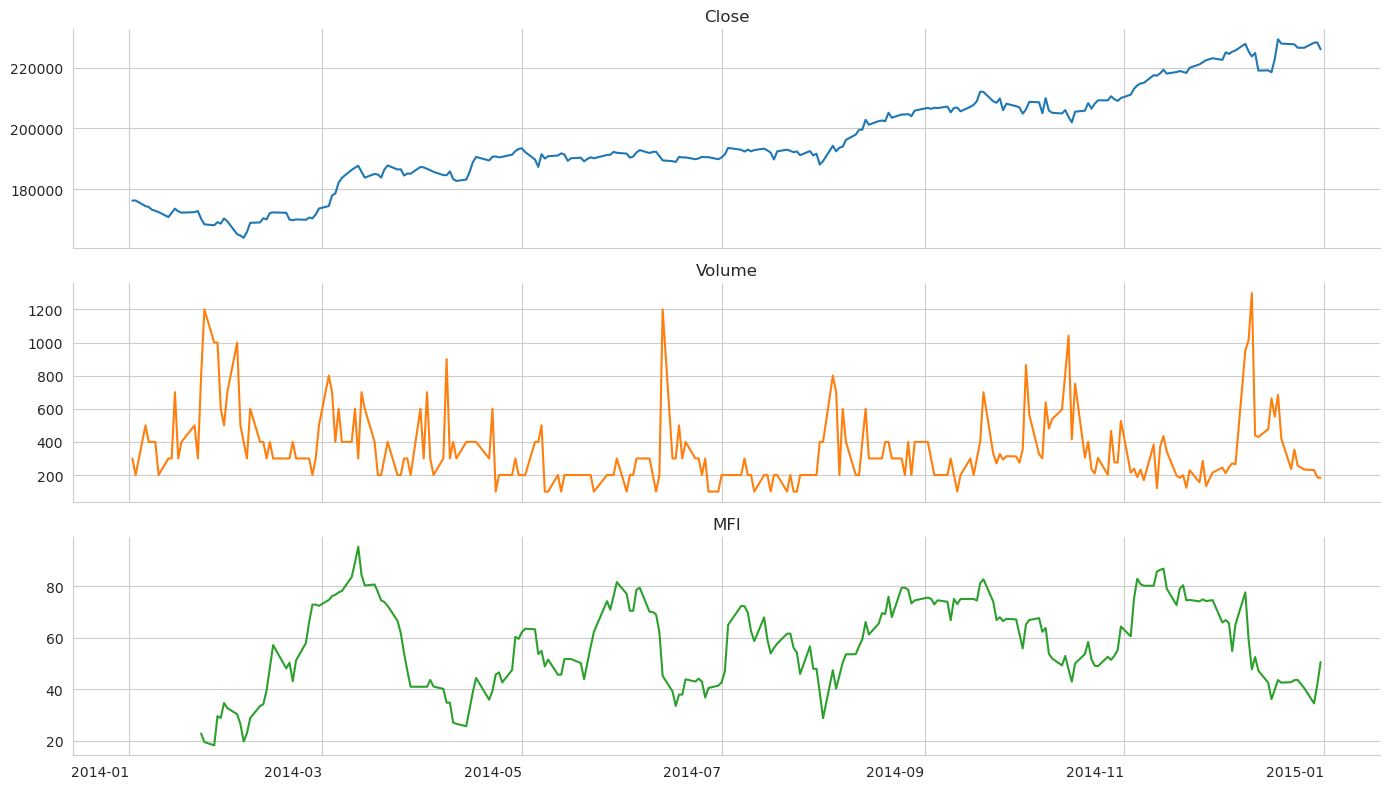

In [155]:
df = price_sample.loc['2014', ['high', 'low', 'close', 'volume']]
df['MFI'] = talib.MFI(df.high, 
                      df.low, 
                      df.close, 
                      df.volume, 
                      timeperiod=14)
axes = df[['close', 'volume', 'MFI']].plot(figsize=(14, 8),
                                           rot=0,
                                           subplots=True,
                                           title=['Close', 'Volume', 'MFI'],
                                           legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

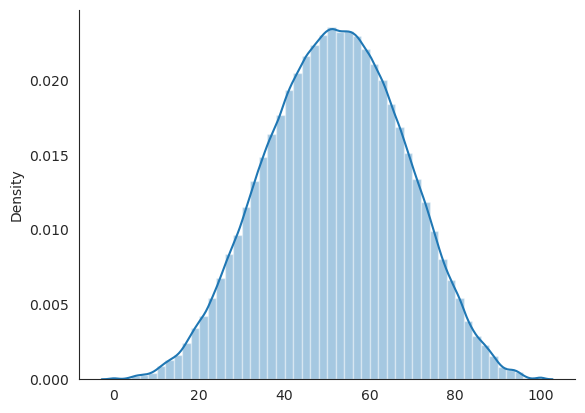

In [156]:
mfi = (inliers.groupby('ticker')
       .apply(lambda x: talib.MFI(x.high, x.low, x.close, x.volume, timeperiod=14))
      )
with sns.axes_style('white'):
    sns.distplot(mfi)
    sns.despine()

### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



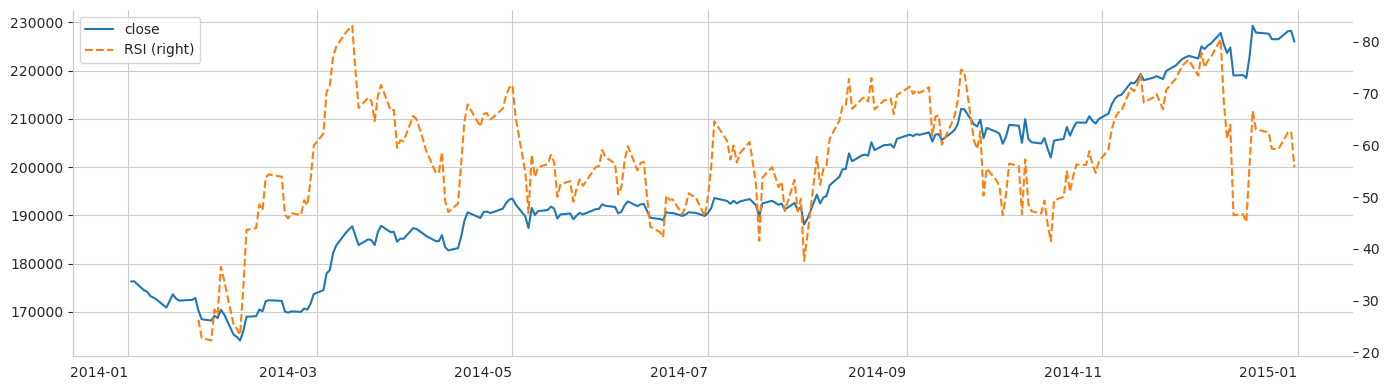

In [157]:
df = price_sample.loc['2014', ['close']]
df['RSI'] = talib.RSI(df.close, timeperiod=14)
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

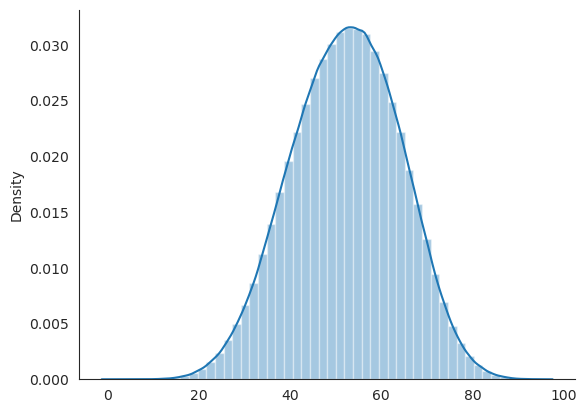

In [158]:
rsi = (inliers.groupby('ticker')
               .apply(lambda x: talib.RSI(x.close,
                                          timeperiod=14)))
with sns.axes_style('white'):
    sns.distplot(rsi)
    sns.despine();

#### Stochastic RSI (STOCHRSI)

The Stochastic Relative Strength Index (STOCHRSI) is based on the RSI just described and intends to identify crossovers as well as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period. It is computed as follows:

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

The TA-Lib implementation offers more flexibility than the original "Unsmoothed stochastic RSI" version by Chande and Kroll (1993). To calculate the original indicator, keep the `timeperiod` and `fastk_period` equal. 

The return value `fastk` is the unsmoothed RSI. The `fastd_period` is used to compute a smoothed STOCHRSI, which  is returned as `fastd`. If you do not care about STOCHRSI smoothing, just set `fastd_period` to 1 and ignore the `fastd` output.

Reference: "Stochastic RSI and Dynamic Momentum Index" by Tushar Chande and Stanley Kroll Stock&Commodities V.11:5 (189-199)


### Stochastic (STOCH)

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. Stochastic oscillators are based on the idea that closing prices should confirm the trend.

For stochastic (STOCH), there are four different lines: `FASTK`, `FASTD`, `SLOWK` and `SLOWD`. The `D` is the signal line usually drawn over its corresponding `K` function.

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$
  

The $P_{T_K}^L$, $P_{T_K}^H$, and $P_{T_K}^L$ are the extreme values among the last $T_K$ period.
 $K^\text{Slow}$ and $D^\text{Fast}$ are equivalent when using the same period. 

### Ultimate Oscillator (ULTOSC)

The Ultimate Oscillator (ULTOSC), developed by Larry Williams, measures the average difference of the current close to the previous lowest price over three time frames (default: 7, 14, and 28) to avoid overreacting to short-term price changes and incorporat short, medium, and long-term market trends. It first computes the buying pressure, $\text{BP}_t$, then sums it over the three periods $T_1, T_2, T_3$, normalized by the True Range ($\text{TR}_t$.
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

ULTOSC is then computed as a weighted average over the three periods as follows:
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

### Williams' %R (WILLR)

Williams %R, also known as the Williams Percent Range, is a momentum indicator that moves between 0 and -100 and measures overbought and oversold levels to identify entry and exit points. It is similar to the Stochastic oscillator and compares the current closing price $P_t^\text{Close}$ to the range of highest ($P_T^\text{High}$) and lowest ($P_T^\text{Low}$) prices over the last T periods (typically 14). The indicators is computed as:

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


## Volume Indicators

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

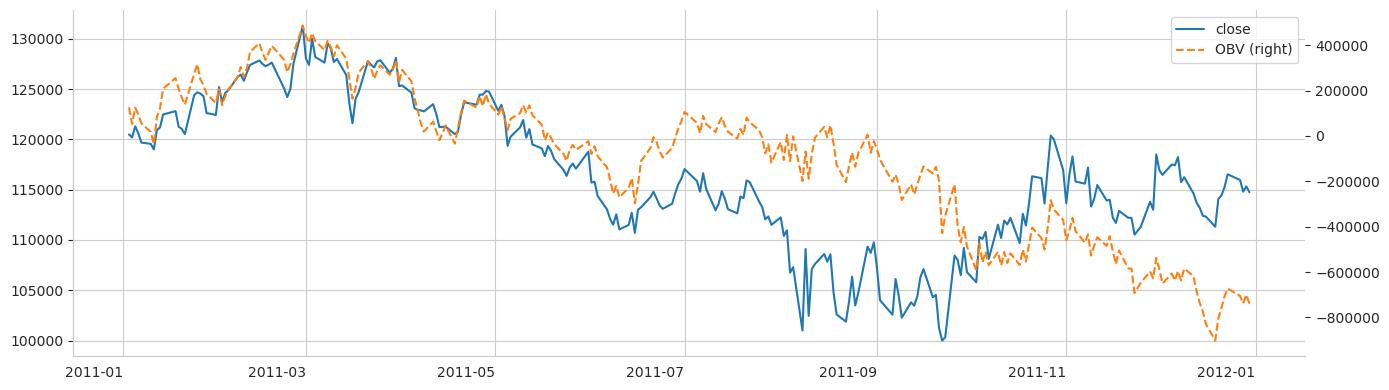

In [159]:
df = price_sample.loc['2011', ['close', 'volume']]
df['OBV'] = talib.OBV(df.close, df.volume)
ax = df[['close', 'OBV']].plot(figsize=(14, 4),
                               rot=0,
                               secondary_y='OBV', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

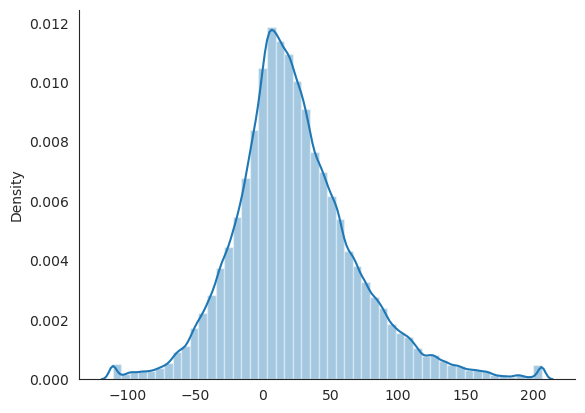

In [160]:
obv = inliers.groupby('ticker').apply(lambda x: talib.OBV(x.close, x.volume) / x.expanding().volume.mean())
q = 0.0025
with sns.axes_style('white'):
    sns.distplot(obv.clip(lower=obv.quantile(q),
                          upper=obv.quantile(1-q)))
    sns.despine()

## Volatility Indicators

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

## Rolling Factor Betas

In [161]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=1998)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

factors = factor_data.columns[:-1]
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [162]:
history.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6785431 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   open           float64
 1   high           float64
 2   low            float64
 3   close          float64
 4   volume         float64
 5   dollar_volume  float64
dtypes: float64(6)
memory usage: 336.7+ MB


In [172]:
keep_tickers = inliers.index.unique('ticker').sort_values()

In [173]:
to_drop = history.index.unique('ticker').difference(keep_tickers)
len(to_drop)

2046

In [174]:
history = history.drop(to_drop, level='ticker')
history.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1318234 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           1318234 non-null  float64
 1   high           1318234 non-null  float64
 2   low            1318234 non-null  float64
 3   close          1318234 non-null  float64
 4   volume         1318234 non-null  float64
 5   dollar_volume  1318234 non-null  float64
dtypes: float64(6)
memory usage: 65.5+ MB


In [175]:
t = 1
ret = f'ret_{t:02}'
windows = [63, 252]

for window in windows:
    print(window)
    betas = []
    for ticker, df in inliers.groupby('ticker', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    history = history.join(betas)

63
252


In [176]:
history

open        high         low       close     volume  \
ticker date                                                                    
A      2006-01-03   22.786839   22.909642   22.387796   22.855063  3796200.0   
       2006-01-04   22.889175   23.080202   22.766372   22.916465  3001300.0   
       2006-01-05   22.820951   23.516836   22.820951   23.516836  3458800.0   
       2006-01-06   23.537304   23.735153   23.257585   23.639640  4396500.0   
       2006-01-09   23.639640   23.741976   23.482724   23.571416  2920500.0   
...                       ...         ...         ...         ...        ...   
ZMH    2015-06-22  113.280000  113.915000  112.980000  113.400000   825030.0   
       2015-06-23  113.700000  113.770000  112.200000  112.680000   825724.0   
       2015-06-24  112.500000  115.500000  112.160100  113.520000  3486819.0   
       2015-06-25  113.530000  114.210000  112.920000  113.270000  1581017.0   
       2015-06-26  113.700000  114.090000  113.110000  113.560000  1802629.0   

                   dollar_volume  ALPHA_63  MARKET_63    SMB_63    HML_63  \
ticker date                                                                 
A      2006-01-03   8.676239e+07       NaN        NaN       NaN       NaN   
       2006-01-04   6.877919e+07       NaN        NaN       NaN       NaN   
       2006-01-05   8.134003e+07       NaN        NaN       NaN       NaN   
       2006-01-06   1.039317e+08       NaN        NaN       NaN       NaN   
       2006-01-09   6.884032e+07       NaN        NaN       NaN       NaN   
...                          ...       ...        ...       ...       ...   
ZMH    2015-06-22   9.355840e+07 -0.001078   0.008933  0.002173 -0.006448   
       2015-06-23   9.304258e+07 -0.001034   0.008537  0.002445 -0.006875   
       2015-06-24   3.958237e+08 -0.000996   0.008188  0.002844 -0.007471   
       2015-06-25   1.790818e+08 -0.001077   0.008314  0.002756 -0.007490   
       2015-06-26   2.047065e+08 -0.000994   0.008612  0.002663 -0.006303   

                     RMW_63    CMA_63  ALPHA_252  MARKET_252   SMB_252  \
ticker date                                                              
A      2006-01-03       NaN       NaN        NaN         NaN       NaN   
       2006-01-04       NaN       NaN        NaN         NaN       NaN   
       2006-01-05       NaN       NaN        NaN         NaN       NaN   
       2006-01-06       NaN       NaN        NaN         NaN       NaN   
       2006-01-09       NaN       NaN        NaN         NaN       NaN   
...                     ...       ...        ...         ...       ...   
ZMH    2015-06-22 -0.002173 -0.003727  -0.000184    0.010540 -0.000422   
       2015-06-23 -0.001864 -0.004287  -0.000191    0.010531 -0.000474   
       2015-06-24 -0.002212 -0.006100  -0.000113    0.010415 -0.000507   
       2015-06-25 -0.002307 -0.005645  -0.000155    0.010394 -0.000561   
       2015-06-26 -0.000948 -0.004726  -0.000132    0.010406 -0.000539   

                    HML_252   RMW_252   CMA_252  
ticker date                                      
A      2006-01-03       NaN       NaN       NaN  
       2006-01-04       NaN       NaN       NaN  
       2006-01-05       NaN       NaN       NaN  
       2006-01-06       NaN       NaN       NaN  
       2006-01-09       NaN       NaN       NaN  
...                     ...       ...       ...  
ZMH    2015-06-22 -0.007510 -0.001471  0.007196  
       2015-06-23 -0.007527 -0.001482  0.007114  
       2015-06-24 -0.007383 -0.001404  0.006764  
       2015-06-25 -0.007627 -0.001447  0.007220  
       2015-06-26 -0.007598 -0.001359  0.007299  

[1318234 rows x 18 columns]

## Persist results

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    pass